In [ ]:
!curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
!curl https://packages.microsoft.com/config/ubuntu/$(lsb_release -rs)/prod.list > /etc/apt/sources.list.d/mssql-release.list

!apt-get update
!ACCEPT_EULA=Y apt-get install -y msodbcsql18
# optional: for bcp and sqlcmd
!ACCEPT_EULA=Y apt-get install -y mssql-tools18
!echo 'export PATH="$PATH:/opt/mssql-tools18/bin"' >> ~/.bashrc
!source ~/.bashrc
# optional: for unixODBC development headers
!apt-get install -y unixodbc-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   983  100   983    0     0   7679      0 --:--:-- --:--:-- --:--:--  7740
OK
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    77  100    77    0     0    916      0 --:--:-- --:--:-- --:--:--   916
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:5 https://packages.microsoft.com/ubuntu/18.04/prod bionic InRelease [4,003 B]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease

In [ ]:
!apt-get --assume-yes install freetds-dev freetds-bin
!pip install pymssql

!apt-get install tdsodbc freetds-bin
!pip install pyodbc

! > /etc/odbcinst.ini
!echo -e "[FreeTDS]\nDescription=FreeTDS\nDriver=/usr/lib/x86_64-linux-gnu/odbc/libtdsodbc.so\nSetup=/usr/lib/x86_64-linux-gnu/odbc/libtdsS.so\nUsageCount=1" > /etc/odbcinst.ini
!cat /etc/odbcinst.ini

!pip install pmdarima

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freetds-dev is already the newest version (1.00.82-2ubuntu0.1).
freetds-bin is already the newest version (1.00.82-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tdsodbc is already the newest version (1.00.82-2ubuntu0.1).
freetds-bin is already the newest version (1.00.82-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-pytho

In [ ]:
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")
# Importing the libraries
import os
import pyodbc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# STEP 1: PREPARE DATA FOR ANALYSIS

connet to sql

In [ ]:
conn = pyodbc.connect('DRIVER={FreeTDS};SERVER=222.252.14.117;PORT=1433;DATABASE=datathon;UID=datathon;PWD=KPIMDatathon2022;TDS_Version=8.0')
cursor = conn.cursor()

get data from sql

In [ ]:
trend_data = pd.read_sql_query('''
select  [Ngay_Dat_Hang] as date, COUNT(Distinct(Ma_Don_Hang)) as sales 
from ecommerce_data
group by [Ngay_Dat_Hang]
order by [Ngay_Dat_Hang]
''', conn)
# Create data frame
df = pd.DataFrame(trend_data)
#Read data
df.head(5)

,date,sales
0,2019-07-01,35442
1,2019-07-02,23781
2,2019-07-03,19787
3,2019-07-04,29155
4,2019-07-05,16143


In [ ]:
df.describe()

,sales
count,184.00
mean,24775.55
std,8314.85
min,3190.00
25%,19313.50
50%,23692.00
75%,29060.50
max,63858.00


In [ ]:
 df.date = pd.to_datetime(df.date, yearfirst = True)
 df.set_index("date", inplace = True)
 df= df.asfreq("d")
 df.head()

,sales
date,
2019-07-01,35442
2019-07-02,23781
2019-07-03,19787
2019-07-04,29155
2019-07-05,16143


In [ ]:
df.isna().sum()

sales    0
dtype: int64

Text(0, 0.5, 'Sales ($)')

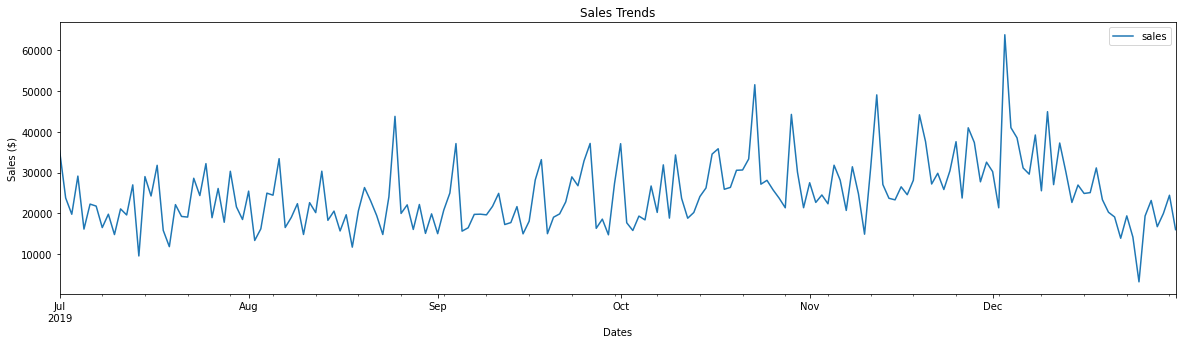

In [ ]:
ax = df.plot(figsize= (20,5))
ax.set_title('Sales Trends')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')

# STEP 2: DECOMPISION OF TIME SERIES DATA

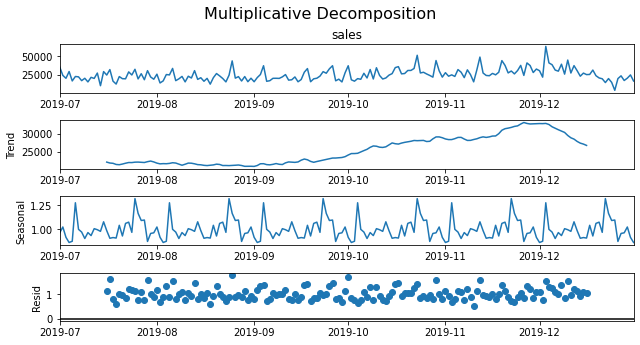

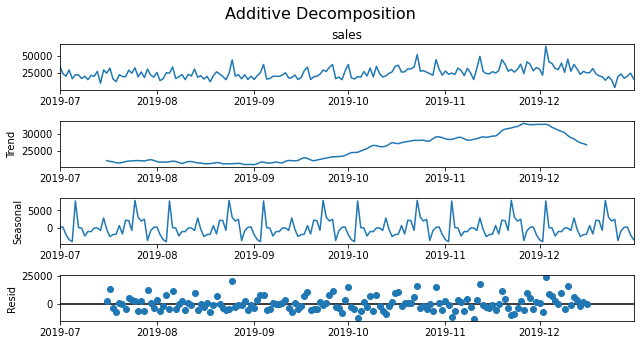

In [ ]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['sales'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(df['sales'], model='additive', period=30)
# Plot
plt.rcParams.update({'figure.figsize': (9,5)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# stationary check

In [ ]:
def check_stationarity(df): # df: array_like, 1d
 dftest = adfuller(df)
 adf = dftest[0]
 pvalue = dftest[1]
 critical_value = dftest[4]['5%']
 print('ADF Statistic: %f' % adf)
 print('p-value: %f' % pvalue)
 if (pvalue < 0.05) and (adf < critical_value): print('The series is stationary')
 else: print('The series is NOT stationary')

check_stationarity(df['sales'])

ADF Statistic: -1.789503
p-value: 0.385685
The series is NOT stationary


# differencing

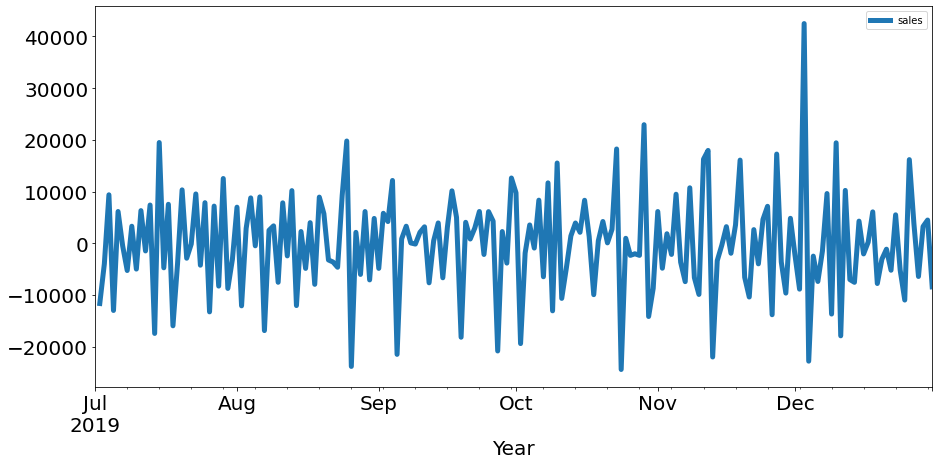

In [ ]:
df.diff().plot(figsize=(15,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

# Autocorrelations and Choosing Model Order

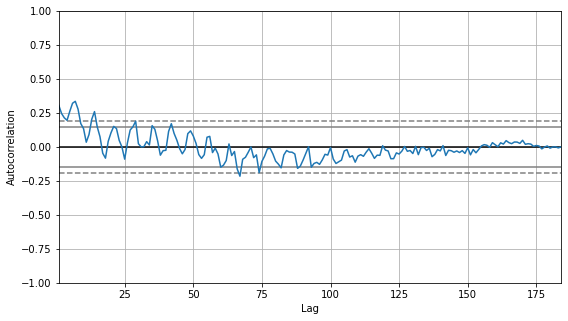

In [ ]:
autocorrelation_plot(df);

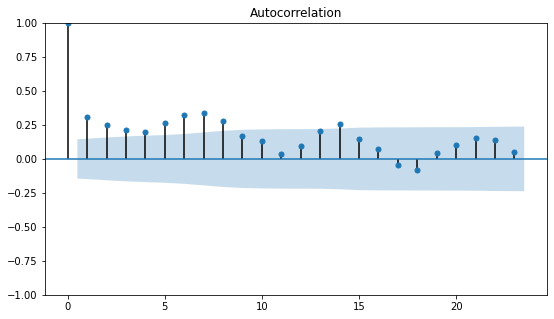

In [ ]:
plot_acf(df);

# Fitting a model

In [ ]:
# fit model
# order (p, d, q)
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
model = ARIMA(df, order=(7,1,0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  184
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -1887.403
Date:                Thu, 24 Nov 2022   AIC                           3790.805
Time:                        08:20:38   BIC                           3816.481
Sample:                    07-01-2019   HQIC                          3801.213
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8574      0.078    -10.996      0.000      -1.010      -0.705
ar.L2         -0.7768      0.110     -7.041      0.000      -0.993      -0.561
ar.L3         -0.7008      0.126     -5.552      0.0

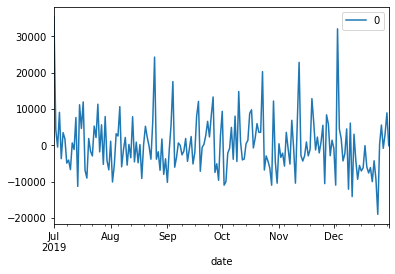

In [ ]:
# plot residual errors
residuals = pd.DataFrame(results.resid)
residuals.plot()


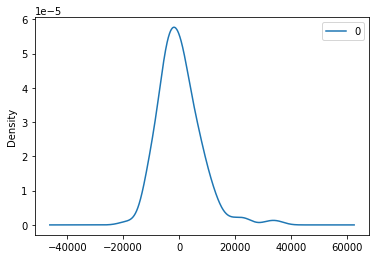

In [ ]:
residuals.plot(kind='kde')

In [ ]:
print(residuals.describe())

              0
count    184.00
mean     168.57
std     7735.96
min   -19039.40
25%    -4591.85
50%     -799.44
75%     3771.14
max    35442.00


In [ ]:
# Define the p, d and q parameters 
# In our example, we only take values between 0 and 2 to make the computation faster
import itertools
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
import statsmodels.api as smf

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = smf.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4242.968045197971
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3881.1035100247705
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3676.523825619981
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3375.4606746128075
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3689.796748520899
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3640.0905794908185
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3413.241368085813
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3375.2216813952455
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4120.874028644479
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3826.781553196497
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3650.402992798973
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3349.6950465704545
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3845.944543916069
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3797.800891020066
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3405.8909246844833
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3350.051317787398
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3861.3150632712013
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3612.0998593927734
AR

In [ ]:
results.aic

3329.0790886585246

In [ ]:
mod = smf.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0472      0.223      0.212      0.832      -0.389       0.484
ma.L1         -0.8075      0.139     -5.826      0.000      -1.079      -0.536
ar.S.L12      -0.1787      0.239     -0.748      0.454      -0.647       0.290
ma.S.L12      -0.7403      0.150     -4.946      0.000      -1.034      -0.447
sigma2      1.466e+08   1.91e-10   7.66e+17      0.000    1.47e+08    1.47e+08


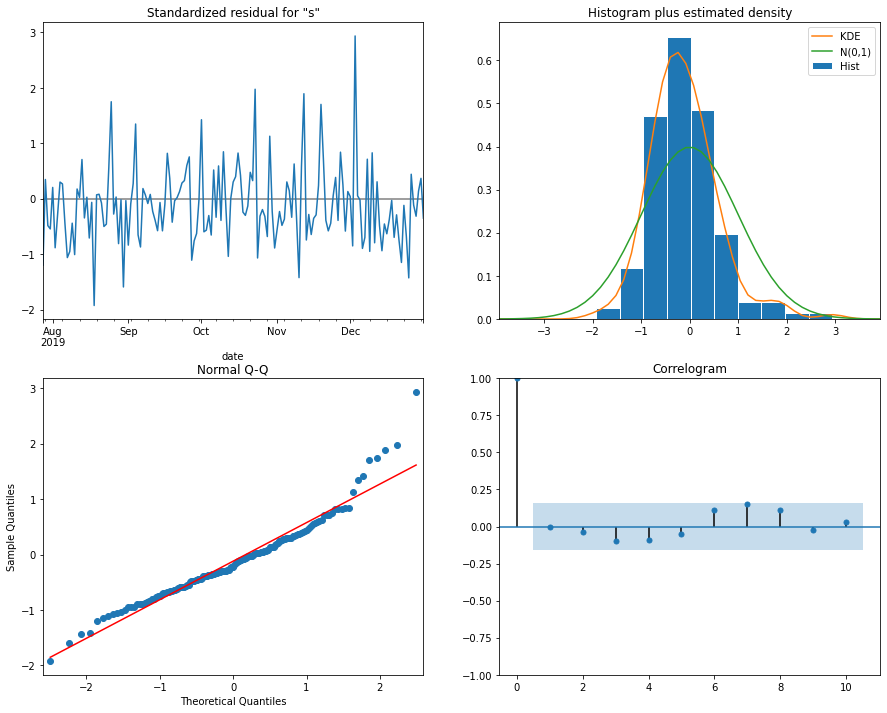

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-12-01'), dynamic=False)
pred_ci = pred.conf_int()

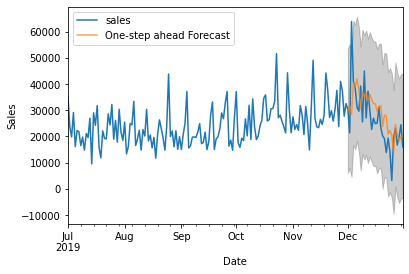

In [ ]:
ax = df['2019':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [ ]:
# Forecasts
df['y_forecasted'] = pred.predicted_mean
df['error_sq_2'] = (df['sales'] - pred.predicted_mean)**2
# Drop NAs and generate new DataFrame
df_pred = df.dropna()
# Sum of squared residuals (SS_R)
SS_R = df_pred['error_sq_2'].sum()
# calculate mean squared error of the model:
# Number of obeservations (lenght of DataFrame)
n = len(df_pred["error_sq_2"])
# calculate mse
mse = round((SS_R/(n-1)),2)
# print output
print('Mean squared error:', mse)

Mean squared error: 101974515.82
